### 다변량 (multivariate) & 다중시점 (multi step) 시계열 예측

- Tensorflow 의 Keras 활용한 LSTM 모델 활용 

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [2]:
df = pd.read_csv('climate.csv')
df.head(3)

,Unnamed: 0,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


In [3]:
# 단변량(Univariate) 데이터셋 만들기 

multi_data = df[['p (mbar)', 'T (degC)', 'rho (g/m**3)']]
multi_data.index = df['Date Time']
print(multi_data.info())
multi_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 115701 entries, 01.01.2009 00:10:00 to 14.03.2011 11:50:00
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   p (mbar)      115701 non-null  float64
 1   T (degC)      115701 non-null  float64
 2   rho (g/m**3)  115701 non-null  float64
dtypes: float64(3)
memory usage: 3.5+ MB
None


,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


[[ 0.9727567  -1.72072556  2.00629096]
 [ 0.97827655 -1.76518439  2.05607584]
 [ 0.97386067 -1.77658408  2.06676137]
 ...
 [ 0.08406095  0.3448998  -0.34816938]
 [ 0.08847683  0.36997914 -0.37026901]
 [ 0.08847683  0.43267748 -0.4287966 ]] (115701, 3) <class 'numpy.ndarray'>


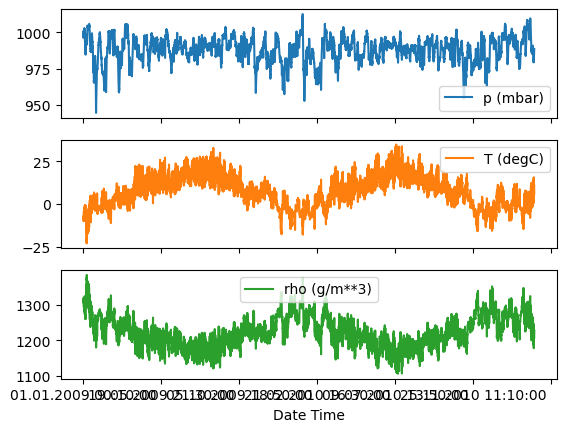

In [4]:
# 데이터셋 시각화 및 정규화 진행

# visualization
multi_data.plot(subplots=True)
TRAIN_SPLIT = 70000

# standardization
dataset = multi_data.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset, dataset.shape, type(dataset))

- 다변량 시계열 데이터셋을 슬라이딩 윈도우 형태로 생성 
- 단일시점 예제와 동일하나, multi step (구간 예측 = 다중시점 예측)이 가능하도록 설정. 아래 코드에서는 과거 720개 시점을 6개 step으로 추출해서 타임 윈도를 구성하여 인풋으로 하고, 미래 72개 시점을 아웃풋으로 예

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):   # 다변량은 타겟을 따로 명시해줘야한다.
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)  # window size = history_size // step
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])   # single step 예측이라면
        else:
            labels.append(target[i:i + target_size])   # multi step 이라면 (=구간예측)
    return np.array(data), np.array(labels)
    
    past_history = 720
    
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape)) # multi step 이기 때문에 target이 72개 값    

print(x_train_multi.shape, y_train_multi.shape, x_val_multi.shape, y_val_multi.shape)

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_multivariate = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_multivariate = train_multivariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_multivariate = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_multivariate = val_multivariate.batch(BATCH_SIZE)

Single window of past history : (120, 3)

 Target temperature to predict : (72,)
(69280, 120, 3) (69280, 72) (44909, 120, 3) (44909, 72)


#### LSTM 모델 생성, 학습, 검증

다중시점 구간 예측이기 때문에 LSTM 의 dense lyaer의 최종 output의 차원은 예측하고자 하는 구간의 길이 여야함

In [7]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(future_target))
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_multivariate.take(1):     # Dateset을 배치단위로 만들었기 때문에, 검증 데이터셋의 첫번째 batch 에 대한 예측 결과를 출력함 => (256,72,1)
    print(multi_step_model.predict(x).shape)

print(f'예측과 타겟 shape 비교 : 타겟값 : {y_val_multi[0].shape} ')

8/8 [==============================] - 0s 6ms/step
(256, 72)
예측과 타겟 shape 비교 : 타겟값 : (72,) 


- LSTM 모델 학습 및 예측 결과 확인
- epoch 별 학습,검증 데이터셋의 예측 오차는 History 객체로 반환할 수 있다. 

In [9]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

multi_step_history = multi_step_model.fit(train_multivariate, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_multivariate,
                                          validation_steps=50)
                                          
# multi_step_history.history 로 검증오차 반환가능
                                          

# 예측값과 타겟값 형태 확인 
for x, y in val_multivariate.take(1):
  true_values = y
  multi_step_predictions = multi_step_model.predict(x)
  
print(true_values.shape, multi_step_predictions.shape, type(true_values), type(multi_step_predictions))

true_values = np.concatenate(true_values, axis=0)
predicted_values = np.concatenate(multi_step_predictions, axis=0)

print(true_values.shape, predicted_values .shape, type(true_values), type(predicted_values ))

mae_loss = tf.keras.losses.MeanAbsoluteError()
mae = mae_loss(true_values, predicted_values)
print(f'Mean Absolute Error: {mae}')

Epoch 1/5
200/200 [==============================] - 13s 66ms/step - loss: 0.2341 - val_loss: 0.2377
Epoch 2/5
200/200 [==============================] - 13s 67ms/step - loss: 0.2078 - val_loss: 0.2202
Epoch 3/5
200/200 [==============================] - 14s 69ms/step - loss: 0.1933 - val_loss: 0.2538
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.1903 - val_loss: 0.2259
Epoch 5/5
8/8 [==============================] - 0s 9ms/step
(256, 72) (256, 72) <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'numpy.ndarray'>
(18432,) (18432,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Mean Absolute Error: 0.17521238327026367


1/1 [==============================] - 0s 407ms/step


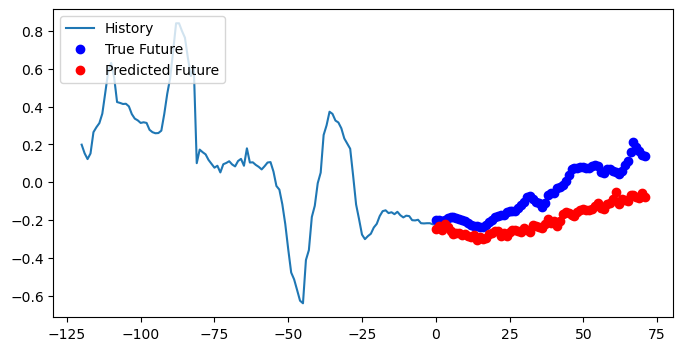

1/1 [==============================] - 0s 26ms/step


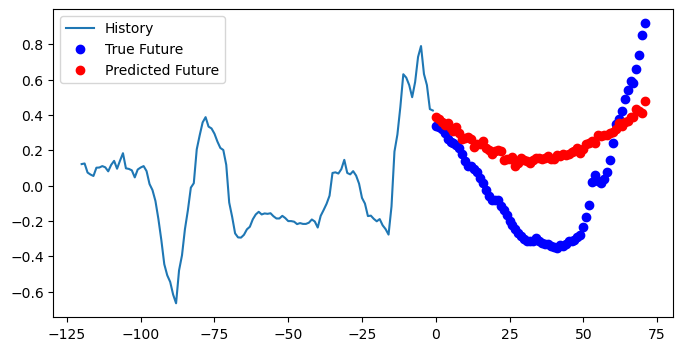

1/1 [==============================] - 0s 22ms/step


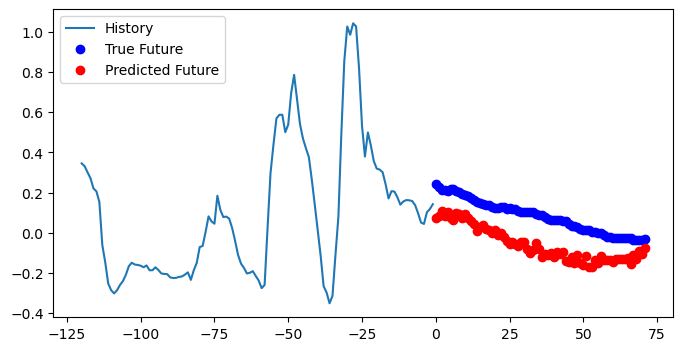

In [10]:
# Plotting the results
def plot_multi_step(history, true_future, prediction):
    plt.figure(figsize=(8, 4))
    num_in = list(range(-len(history), 0))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

# Visualize the prediction
for x, y in val_multivariate.take(3): # Displaying first examples :3개의 배치의 각 첫번째 데이터셋 결과 시각화
    for i in range(1):
        plot_multi_step(x[i], y[i], multi_step_model.predict(np.expand_dims(x[i], axis=0))[0])